In [1]:
import cassiopeia as cas
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ete3 import Tree, TreeStyle
from typing import Tuple
import scipy

In [2]:
TLS2_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_hybrid_newick_noMutationlessEdges_Labeled.nwk'
meta_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_metadata.txt'
character_matrix_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_character_matrix.txt'
priors_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_priors.pickle'
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
clusterFile = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_clusterTable.txt'
allele_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/allele_table_filtered.txt'

In [3]:
colorDictFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(colorDictFile,'rb') as fp:
    colorDict = pickle.load(fp)

In [4]:
allele_table = pd.read_csv(allele_loc, sep = '\t')

In [5]:
tree = Tree(TLS2_loc, format=1)
tree_meta = pd.read_csv(meta_loc, sep='\t')
character_matrix = pd.read_csv(character_matrix_loc, sep='\t', index_col = 0)

with open(priors_loc, 'rb') as f:
    priors = pickle.load(f)
        
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

# Create a cassiopeia Tree        
test_tree = cas.data.CassiopeiaTree(character_matrix = character_matrix, priors = priors, tree = tree)
    
missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T
test_tree.cell_meta = tree_meta
test_tree.character_meta = character_meta

test_tree.cell_meta['cluster'] = test_tree.cell_meta['cell_state'].str[2:-2]
test_tree.cell_meta.set_index("cellBC",inplace = True)

In [6]:
data = pd.read_csv(clusterFile,sep='\t')
data.rename(columns={"Unnamed: 0": "cellBC"},inplace=True)
data.set_index("cellBC",inplace=True)

numClusters = data.shape[1]

In [7]:
with open(colorDictFile,'rb') as fp:
    colorDict = pickle.load(fp)

t = Tree(TLS2_loc,format=1)

data["totalCells"] = data.sum(axis = 1)
colNames = data.columns[0:(data.shape[1] - 1)].values

mCells = data["totalCells"].max()

filling in multiindex table:   0%|          | 0/18912 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.78it/s]


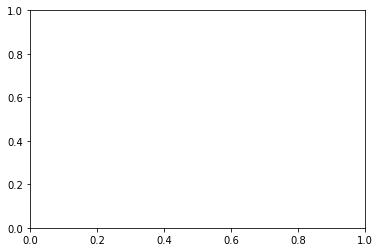

In [8]:
fig, ax = plt.subplots()
cas.pl.plot_matplotlib(test_tree, allele_table = allele_table, orient = 'right', figsize = (10, 40))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/AM-DNA-098_Indel_Heatmap.pdf', dpi = 900)
#plt.show()
plt.close()

In [26]:
def mylayout(node):
    #if node.is_leaf():
    #    node.img_style["size"]=0
    #else:
    cvals = data.loc[node.name,colNames].values
    totalCells = float(cvals.sum())
    if totalCells==0:
        print(node.name)
    pcts = (cvals/totalCells)*100
    idx = np.nonzero(pcts)
    apct = [pcts[i] for i in idx[0]]
    acol = [colorDict[colNames[i]] for i in idx[0]]
    # scale size to total cells
    pSize = mCells/100.
    #pSize = np.log2(totalCells+(mCells/1000.))*0.5
    pSize = np.log2(totalCells) #+(mCells/100.)) # works well
    pSize = 3 
    #pSize = np.log2(totalCells+0.1)
    if pSize<1:
        pSize=1

    if not node.is_root(): 
    # PieChartFace(percents,width,height,colors,line_color) 
        C = faces.PieChartFace(apct,colors=acol,width=pSize,height=pSize)
        C.border.width = None
        C.opacity = 0.8
        #faces.add_face_to_node(C,node,0,position="branch-bottom") # opt1: branch bottom
        faces.add_face_to_node(C,node,position="float",column=0) # opt2: float

    node.img_style["size"]=0

In [27]:
ts = TreeStyle()
#ts.layout_fn = mylayout
ts.show_leaf_name = False
ts.show_branch_length = False
ts.allow_face_overlap = True
#ts.min_leaf_separation = 0
ts.mode = "r"
ts.show_scale = False

In [28]:
outfile = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-098/lineage/2_lineage_reconstruction/AM-DNA-098_Linear_Plot.pdf'
outSizeLen = 10
outSizeHeight=10

In [ ]:
t.render(file_name=outfile,w=outSizeLen,h=outSizeHeight,units="in",tree_style=ts)